# Analyzing the Impact of Ascites and D-Penicillamine on Mortality in Primary Biliary Cirrhosis Patients: A Statistical Inference Study
#### Authors: Hrishi Logani, Rithika Nair, Yuxi Zhang, Yuexiang Ni (Group 43)

## 1. Introduction

Primary biliary cirrhosis (PBC) is a chronic condition characterized by gradual damage and deterioration of the liver's bile ducts, leading to substantial liver-related health challenges. PBC stands as a prominent contributor to liver-related illnesses and fatalities. The prognosis of PBC is influenced by multiple factors critical to effective treatment (Prince et al., 2002). Notably, advanced PBC often manifests the complication of ascites, characterized by an accumulation of fluid in the abdominal cavity (Purohit, 2015). This project endeavors to examine how ascites impacts the prognosis of patients receiving D-penicillamine. It's worth noting that the effectiveness of D-penicillamine remains uncertain (Purohit, 2015). We chose to analyze this to improve patient treatment insights. Thus, we are asking the following question:

#### For Primary Biliary Cirrhosis patients administered with D-Penicillamine, does the presence of Ascites determine their mortality?

To investigate this, we shall analyze the difference in mortality rate based on the following categorical variables and the scale parameter will be a standard error of proportions.

* Type of treatment (D-penicillamine or Placebo)
* Presence of Ascites

The analysis will focus on comparing proportions, as both "Drug" type and "Ascites" presence have only two discrete outcomes. Standard error will be used to quantify the statistic's variation from the population proportion. This project seeks to provide insights into the impact of "Ascites" on the prognosis of PBC patients treated with "D-penicillamine," using a comprehensive dataset for a thorough investigation.

The dataset used is the __[Cirrhosis Patient Survival Prediction](https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1)__ dataset from the UCI Machine Learning Repository, containing information on 418 PBC patients. Each patient's data includes patient status ("Status"), drug type ("Drug"), age, sex, and various clinical parameters.

## 2. Methods & Results

### Loading Necessary Libraries

In [1]:
install.packages("infer")
install.packages("gridExtra")

library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)


The downloaded binary packages are in
	/var/folders/p5/hwwszq5n2kv_18jljl_3nq1h0000gn/T//RtmpeSYQgs/downloaded_packages

The downloaded binary packages are in
	/var/folders/p5/hwwszq5n2kv_18jljl_3nq1h0000gn/T//RtmpeSYQgs/downloaded_packages


── Attaching packages ─────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.3.0      ✔ stringr 1.5.1 
✔ readr   2.1.4      ✔ forcats 1.0.0 
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
── Conflicts ────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### Downloading Dataset from the Web

* Downloading the dataset that is stored in a public repository.

In [2]:
# URL containing the dataset
url <- "https://raw.githubusercontent.com/Rithika-Nair/STAT-201-Final_Project/main/cirrhosis.csv"

# Download cirrhosis.csv from the url
download.file(url, "cirrhosis.csv")

# Store the dataset into variable
cirr_data <- read.csv("cirrhosis.csv")

# Display the first few rows of the dataset
head(cirr_data)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
1,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261,2.60,156,1718.0,137.95,172,190,12.2,4
2,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302,4.14,54,7394.8,113.52,88,221,10.6,3
3,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176,3.48,210,516.0,96.10,55,151,12.0,4
4,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244,2.54,64,6121.8,60.63,92,183,10.3,4
5,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279,3.53,143,671.0,113.15,72,136,10.9,3
6,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248,3.98,50,944.0,93.00,63,NA,11.0,3


    Table 1: Cirrhosis Dataset
<a id='tab_1'></a>

### Data Cleaning and Preprocessing

* Selecting columns relevant to our analysis: `Status`, `Drug`, `Ascites`.

In [3]:
cirrhosis <- cirr_data %>%
        select(Status, Drug, Ascites)

head(cirrhosis)

,Status,Drug,Ascites
,<chr>,<chr>,<chr>
1,D,D-penicillamine,Y
2,C,D-penicillamine,N
3,D,D-penicillamine,N
4,D,D-penicillamine,N
5,CL,Placebo,N
6,D,Placebo,N


    Table 2: Cirrhosis Dataset with Variables of Interest
<a id='tab_2'></a>

* Checking for missing values in each of the columns and removing the rows that contain missing values.

In [4]:
# Printing the number of missing values in each column
print(sum(is.na(cirrhosis$Status)))
print(sum(is.na(cirrhosis$Drug)))
print(sum(is.na(cirrhosis$Ascites)))

[1] 0
[1] 106
[1] 106


In [5]:
# Filtering out the rows containing NA values in either Drug or Ascites columns
cirrhosis_filtered <- cirrhosis %>%
        filter(!is.na(Drug)) %>%
        filter(!is.na(Ascites)) %>%
        filter(Status %in% c("CL", "D"))

head(cirrhosis_filtered)
nrow(cirrhosis_filtered)

,Status,Drug,Ascites
,<chr>,<chr>,<chr>
1,D,D-penicillamine,Y
2,D,D-penicillamine,N
3,D,D-penicillamine,N
4,CL,Placebo,N
5,D,Placebo,N
6,D,Placebo,N


[1] 144

    Table 3: Refined Cirrhosis Dataset with Variables of Interest
<a id='tab_3'></a>

### Exploratory data analysis


* We shall conduct our analysis by grouping the patients into 2 different groups.
    * Group 1: Patients administered with D-penicillamine and have Ascites
    * Group 2: Patients administered with D-penicillamine but don't have Ascites.




In [6]:
# filtering dataset to include only those administered with D-penicillamine
patients_dp <- cirrhosis_filtered |>
               filter(Drug == "D-penicillamine")
head(patients_dp)

,Status,Drug,Ascites
,<chr>,<chr>,<chr>
1,D,D-penicillamine,Y
2,D,D-penicillamine,N
3,D,D-penicillamine,N
4,D,D-penicillamine,N
5,D,D-penicillamine,N
6,D,D-penicillamine,N


    Table 4: Patients Administered D-pencillamine in Filtered Cirrhosis Dataset
<a id='tab_4'></a>

Now, we will perform bootstrapping to estimate confidence intervals for the proportions of patients with and without Ascites ("Y" and "N"). With a seed for reproducibility, we will conduct 1,000 bootstrap replicates for each category. The resulting confidence intervals will help assess the precision of our estimates, providing a range within which the true population proportion likely lies.

In [7]:
# set seed to ensure reproducability
set.seed(69)

bootstrap_ascites_present <- patients_dp |>
                             specify(response = Ascites, success = "Y") |>
                             generate(type = "bootstrap", reps = 1000) |>
                             calculate(stat="prop")
ascites_present_ci <- bootstrap_ascites_present |>
                      get_ci(level = 0.95, type = "percentile")

ascites_present_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.09333333,0.2666667


    Table 5: 95% Confidence Interval for Patients Exhibiting Ascites
<a id='tab_5'></a>

In [8]:
set.seed(69)

bootstrap_ascites_absent <- patients_dp |>
                            specify(response = Ascites,  success = "N") |>
                            generate(type = "bootstrap", reps = 1000) |>
                            calculate(stat="prop")

ascites_absent_ci <- bootstrap_ascites_absent |>
                      get_ci(level = 0.95, type = "percentile")

ascites_absent_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.7333333,0.9066667


    Table 6: 95% Confidence Interval for Patients Not Exhibiting Ascites
<a id='tab_6'></a>

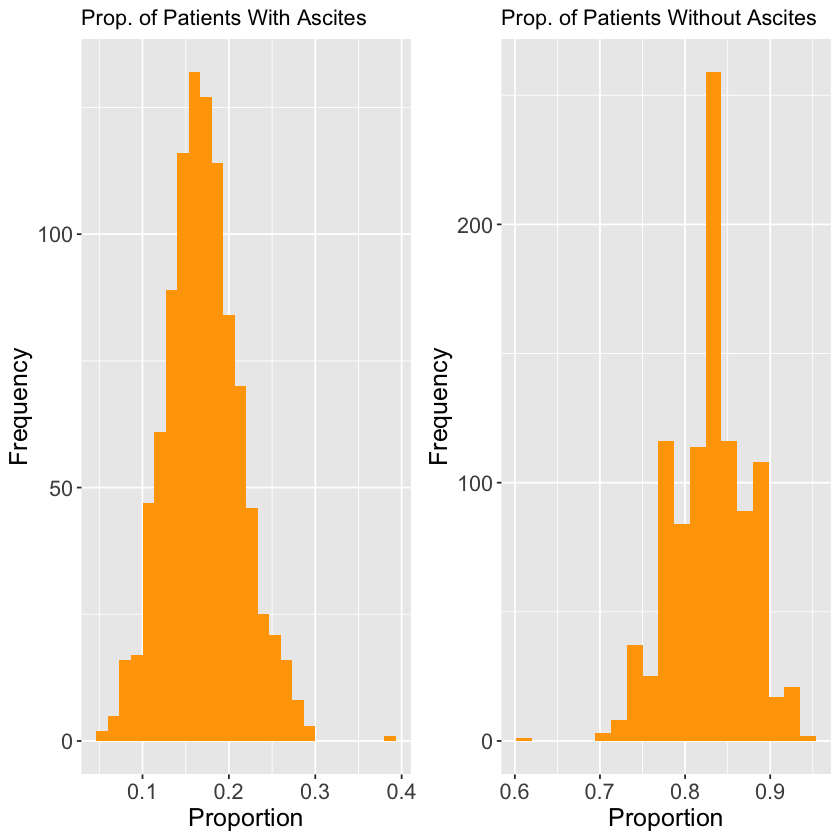

In [9]:
# bootstrap sampling distribution for patients that  have ascites
ascites_present_plot <- bootstrap_ascites_present |>
                        ggplot(aes(x = stat)) +
                        geom_histogram(bins = 26, fill = "orange") +
                        ggtitle("Prop. of Patients With Ascites") +
                        labs(x = "Proportion", y = "Frequency") +
                        theme(axis.text=element_text(size=13),
                              axis.title=element_text(size=15),
                              plot.title = element_text(size=13))

# bootstrap sampling distribution for patients that don't have ascites
ascites_absent_plot <- bootstrap_ascites_absent |>
                       ggplot(aes(x = stat)) +
                       geom_histogram(bins = 19, fill = "orange") +
                       ggtitle("Prop. of Patients Without Ascites") +
                       labs(x = "Proportion", y = "Frequency") +
                       theme(axis.text=element_text(size=13),
                             axis.title=element_text(size=15),
                             plot.title = element_text(size=13))

# Arrange the plots side by side
grid.arrange(ascites_present_plot, ascites_absent_plot, ncol = 2)

    Figure 1: Distribution of Patients with Ascites vs without Ascites.
<a id='fig_2'></a>

Now, we examine the mortality rates within each group to understand the proportion of individuals who have unfortunately passed away.

In [10]:
# Counting the patients who have died in Group 1 and Group 2
patients_dp_died <- patients_dp |>
                    group_by(Ascites) |>
                    filter(Status == "D") |>
                    summarize(count = n())

# patients_dp_died

# Calculating the proportion of patients in Group 1 and Group 2
prop_dp_died <- patients_dp_died |>
                mutate(prop = count/sum(count)) |>
                select(Ascites, prop)

prop_dp_died

Ascites,prop
<chr>,<dbl>
N,0.8
Y,0.2


    Table 7: Proportion of Patients with Ascites Status who have Deceased
<a id='tab_7'></a>

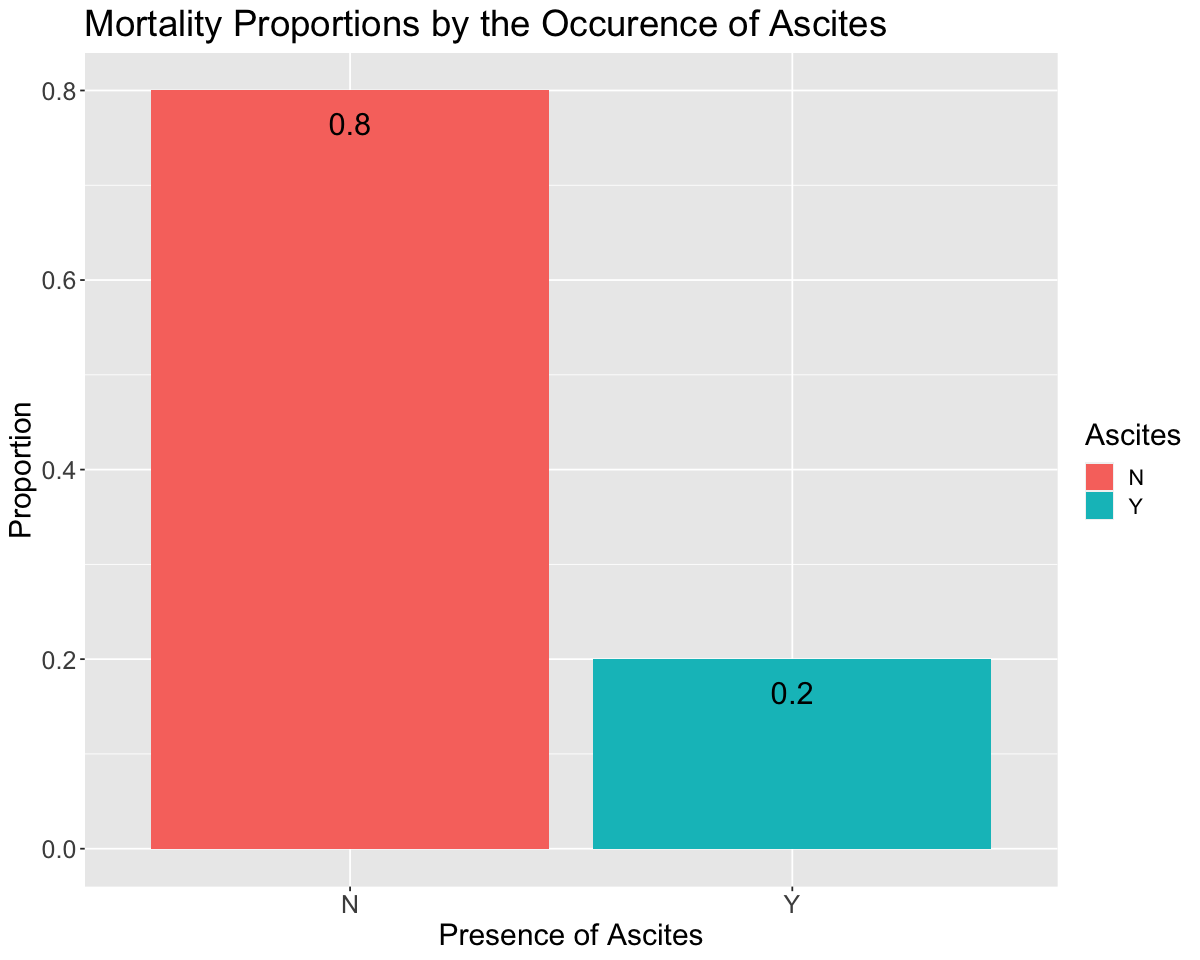

In [11]:
# set the size of the plot (optional)
options(repr.plot.width = 10, repr.plot.height = 8)

# Plot a histogram to visualize the proportions
raw_data_prop_plot <- prop_dp_died |>
              ggplot(aes(x = Ascites, y = prop, fill = Ascites)) +
              geom_col() +
              geom_text(aes(label = prop), vjust=2, size = 6.5) +
              labs(title = "Mortality Proportions by the Occurence of Ascites", x = "Presence of Ascites", y = "Proportion") +
              theme(axis.text=element_text(size=15),
                    axis.title=element_text(size=18),
                    plot.title = element_text(size=22),
                    legend.title = element_text(size=18),
                    legend.text = element_text(size=13))

raw_data_prop_plot

    Figure 2: Mortality Rates Based on the Presence of Ascites.
<a id='fig_2'></a>

[Figure 2](#fig_2) indicates a noteworthy contrast in the mortality rates of the two groups of patients, thus suggesting a significant difference.

### Hypothesis Testing

The estimates produced in the previous section are insufficient as there is no mention of the statistical significance of the evidence. Therefore, we will need to perform hypothesis testing to determine the reliability of our conclusion. We plan to support our data by testing the following hypothesis:

*   $ H_0 : p_1 - p_2 = 0$
*   $ H_1 : p_1 - p_2 \neq 0$



Here, $p_1$ denotes the proportion of patients administered with D-penicillamine and have Ascites who died, while $p_2$ represents the proportion of patients administered with D-penicillamine and do not have ascites but still died. The objective is to assess the statistical evidence supporting our conclusions.
The null hypothesis states that there is no difference in mortality rates between patients administered with D-penicillamine and have Ascites ($p_1$) and those administered with D-penicillamine without ascites ($p_2$) who died whereas the alternative hypothesis states that there is a difference between mortality rates between the two groups.

We have chosen a significance level of $α=0.05$ for our hypothesis testing, striking a balance between the probabilities of type 1 and type 2 errors. Opting for a lower significance level would elevate the risk of committing a type 2 error, which, here, is more consequential than a type 1 error. A type 2 error would imply the erroneous conclusion that there is no difference in mortality rates when, in fact, there is. Conversely, increasing the significance level would necessitate stronger evidence to reach a statistically significant conclusion. Hence, our selected significance level aligns with the objective of minimizing both types of errors while maintaining a practical balance.

Using a two-tailed test to assess mortality rate differences in D-penicillamine patients with and without Ascites ensures a comprehensive analysis, detecting significance in either direction. This approach minimizes the risks of type 1 and type 2 errors, aligning with a thorough evaluation of the research hypothesis while maintaining practicality.

### Creating the null model
*   Now, we shall calculate the summary statistic and make a null distribution using the infer package.


In [12]:
# set seed to ensure that data is reproducible
set.seed(69)

# create the null distribution
null_distribution <- patients_dp |>
                     specify(formula = Status ~ Ascites, success = "D") |>
                     hypothesize(null="independence") |>
                     generate(reps = 1000, type = "permute") |>
                     calculate(stat = "diff in props", order = c("Y", "N"))

head(null_distribution)


replicate,stat
<int>,<dbl>
1,-0.02481390
2,0.06823821
3,0.16129032
4,0.06823821
5,-0.11786600
6,0.16129032


    Table 8: 1000 samples taken from the Null Model using Infer Package
<a id='tab_8'></a>

### Calculating test statistic


*  Now, we shall calculate the observed difference in mortality rates using infer package.



In [13]:
obs_diff_prop <- patients_dp |>
                 specify(Status ~ Ascites, success = "D") |>
                 calculate(stat = "diff in props", order = c("Y", "N"))
obs_diff_prop

stat
<dbl>
0.1612903


    Table 9: Observed Difference In Proportions
<a id='tab_9'></a>

### Visualizing the p-value


*   The final step is to visualize the p-value on the null distribution
*   This means that, if the null hypothesis holds true, how surprised would we be to see a difference in mortality rates of 16.13%?
*   We accomplish this by first visualizing the null distribution using the  function ```visualize()``` function of infer package, and then we shall use ```shade_p_value``` function and set ```obs_stat``` to ```obs_diff_prop``` and we will set the ```direction = "right"``` because our alternative hypothesis is "more extreme" than the hypothesized world.



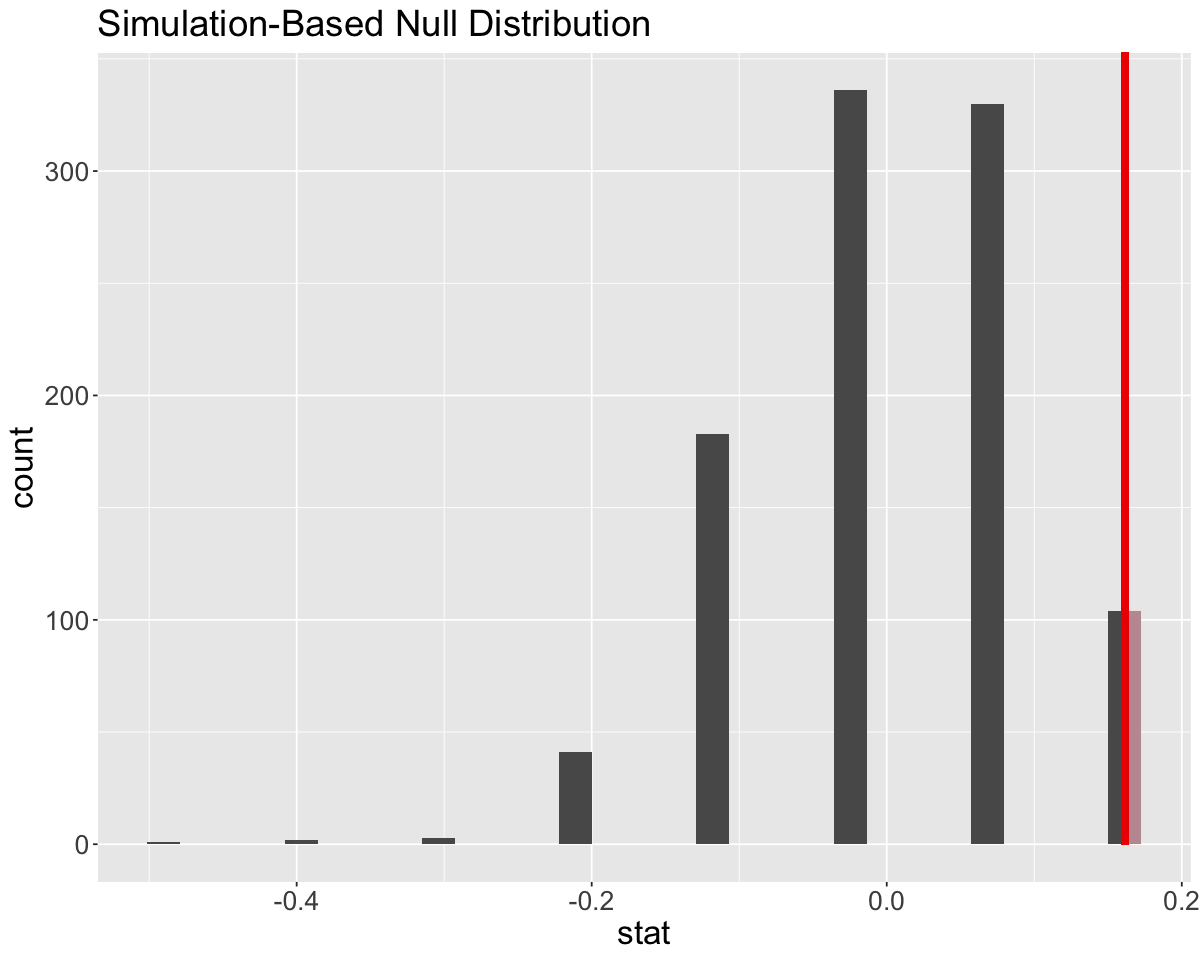

In [14]:
# set the size of the plot
options(repr.plot.width = 10, repr.plot.height = 8)

# visualizing the null distribution
null_plot <- visualise(null_distribution) +
             shade_p_value(obs_stat = obs_diff_prop, direction = "right") +
             theme(axis.text=element_text(size=16),
                    axis.title=element_text(size=20),
                    plot.title = element_text(size=22))

null_plot

    Figure 3: Simulation Based Null Distribution
<a id='fig_3'></a>



*   After visualizing the p-value ([Figure 3](#fig_3)), we can tell that there are chances that we will see a difference in the survival rates of 16.13% in a hypothesized world of no difference in the mortality rates between the two groups.
*   Therefore, we would fail to reject the null hypothesis, in statistical terminology - "Do not reject $H_0$".


### Computing the p-value


*   We shall compute the p-value using ```get_p_value``` function with ```obs_stat = obs_diff_prop``` and ```direction = "right"```.  



In [15]:
p_val <- null_distribution |>
         get_p_value(obs_stat = obs_diff_prop, direction = "right")
p_val

p_value
<dbl>
0.104


    Table 10: P-Value calculated from Null Distribution
<a id='tab_10'></a>



*   This information indicates that there is a 10.4% probability of observing a mortality rate difference as substantial as 16.13% between individuals treated with D-penicillamine, distinguishing between those with and without ascites, solely due to random sampling fluctuations in a null distribution.
*   Since the p-value is larger than our 5% significance level, we fail to reject the null hypothesis.



### Bootstrap method for difference in proportions

*   We shall now use boostrapping methods to test our hypothesis.


In [16]:
# set the seed to ensure that data is reproducible
set.seed(69)

# generating the bootstrapping distribution with reps = 1000
bootstrap_distribution <- patients_dp |>
                          specify(formula = Status ~ Ascites, success = "D") |>
                          generate(reps = 1000, type = "bootstrap") |>
                          calculate(stat="diff in props", order = c("Y", "N"))
head(bootstrap_distribution)

replicate,stat
<int>,<dbl>
1,0.1774194
2,0.1940299
3,0.1896552
4,0.1093750
5,0.1639344
6,0.1641791


    Table 11: 1000 samples taken using Bootstraping with Infer Package
<a id='tab_11'></a>

In [17]:
# generate the upper and lower confidence intervals with 95% confidence level
percentile_ci <- bootstrap_distribution |>
                 get_ci(level = 0.95, type = "percentile")
percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.078125,0.2586769


    Table 12: Upper and Lower Bounds of 95% Confidence Interval from Bootstrapping
<a id='tab_12'></a>

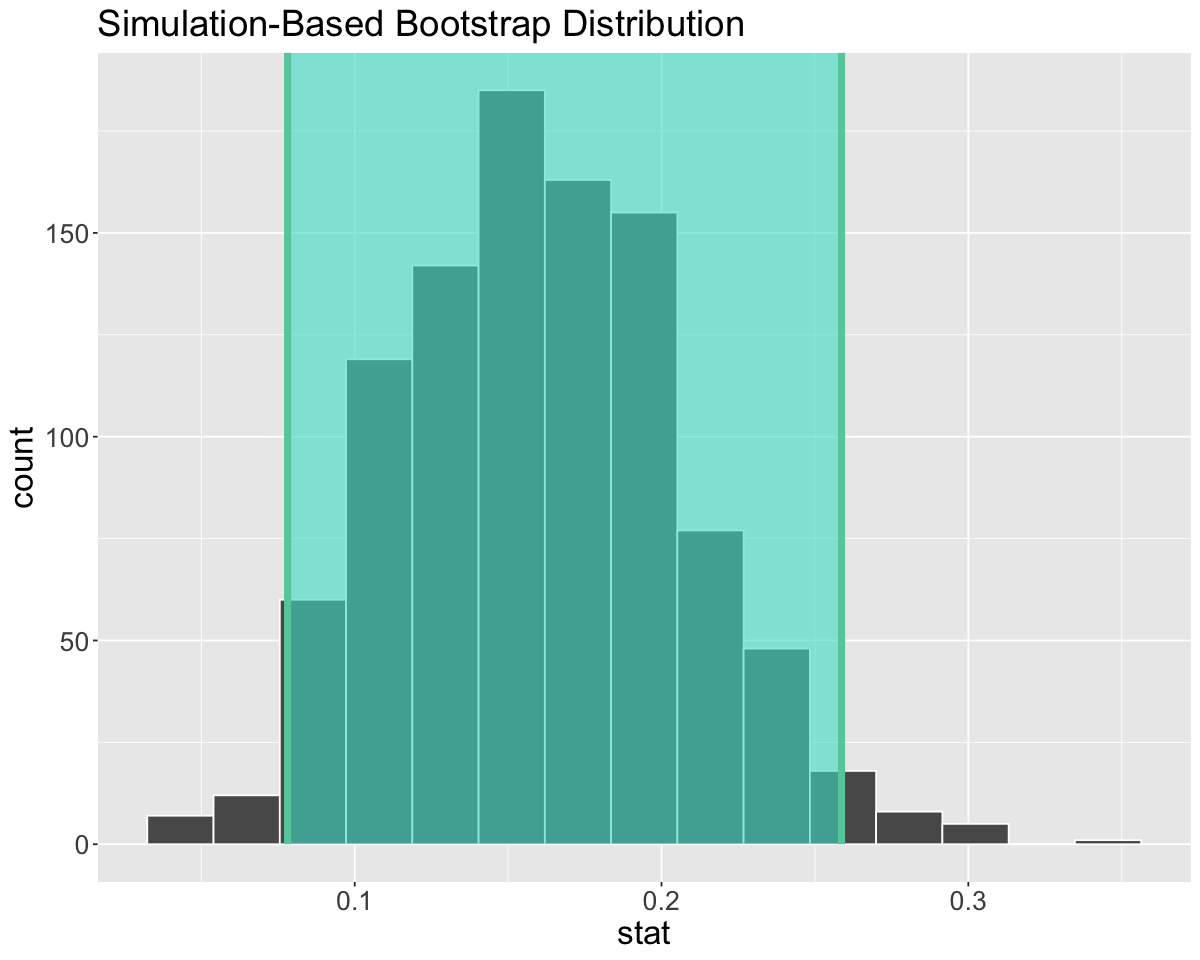

In [18]:
# set the size of the plot
options(repr.plot.width = 10, repr.plot.height = 8)

# visualizing the 95% confidence interval on bootstrap disribution
percentile_ci_plot <- visualize(bootstrap_distribution) +
                      shade_confidence_interval(endpoints = percentile_ci) +
                      theme(axis.text=element_text(size=16),
                            axis.title=element_text(size=20),
                            plot.title = element_text(size=22))

percentile_ci_plot

    Figure 4: Simulation-based Bootstrap Distribution with 95% confidence interval
<a id='fig_4'></a>





*   From [Figure 4](#fig_4), we are 95% confident that the true difference in the population proportions $p_1 - p_2$ lies between 7.81% and 25.86%
*   We can also deduce that our calculated p-value of 0.104 falls within the 95% confidence interval (0.0781, 0.2586), indicating that the disparity between $p_1$ and $p_2$ lacks statistical significance.


### Standard Error Method


*   Since the bootstrap distribution is roughly normally distributed, we can also compare it with the confidence interval generated from the standard error method.
*   Here, we would use the ```get_ci``` function and set ```level = 0.95```,
    ``` type = se``` and ```point_estimate = obs_diff_prop```.



In [19]:
# generating 95% confidence level
se_ci <- bootstrap_distribution |>
         get_ci(level = 0.95, type = "se", point_estimate = obs_diff_prop)
se_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.07090481,0.2516758


    Table 13: Upper and Lower Bounds of 95% Confidence Interval from standard error method
<a id='tab_13'></a>

### Visualize using Standard Error Method


*   Now, we'll visualize the bootstrap distribution again using the confidence interval we calculated using the standard error method.


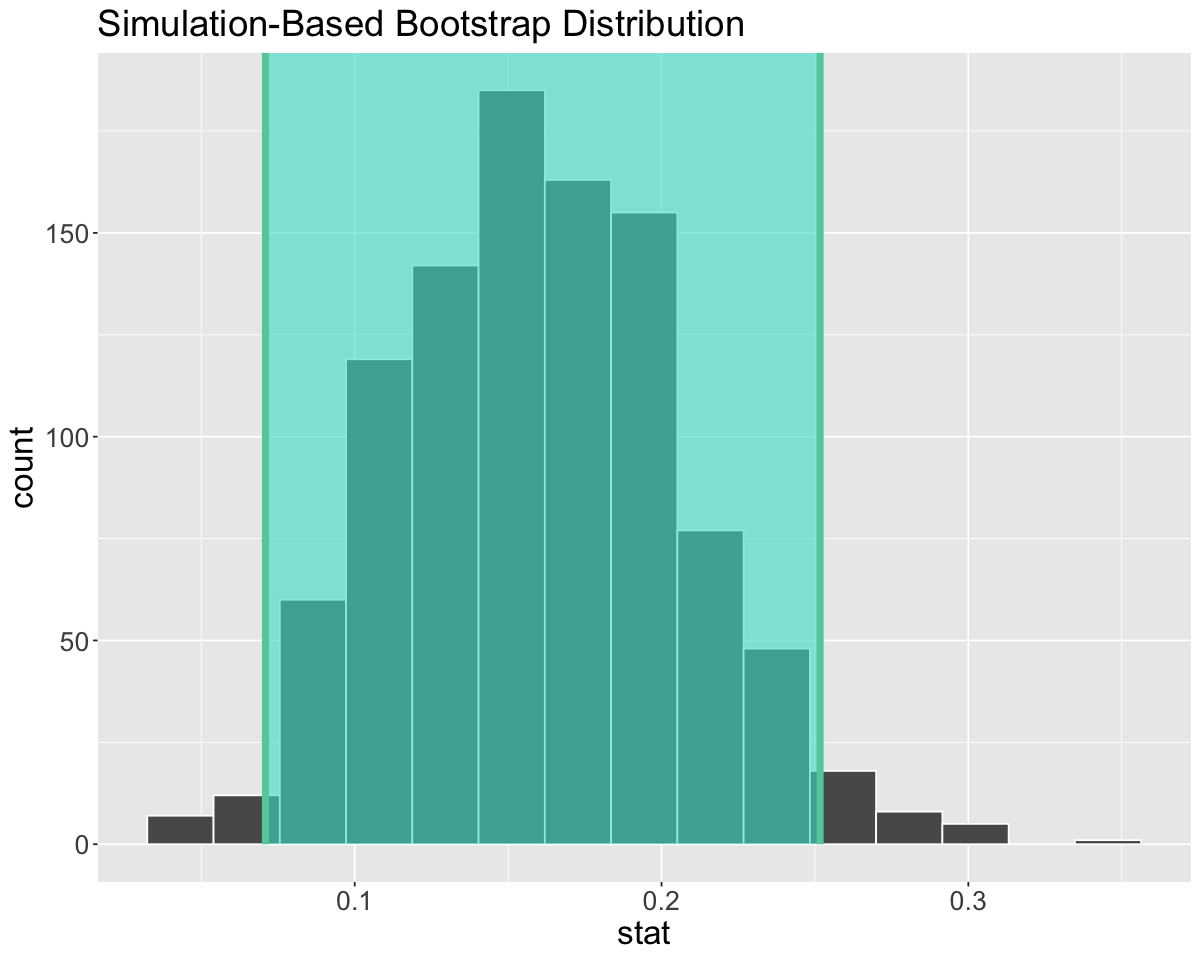

In [20]:
# set the size of the plot
options(repr.plot.width = 10, repr.plot.height = 8)

# visualizing the 95% confidence interval on bootstrap disribution
se_ci_plot <- visualize(bootstrap_distribution) +
              shade_confidence_interval(endpoints = se_ci) +
              theme(axis.text=element_text(size=16),
                    axis.title=element_text(size=20),
                    plot.title = element_text(size=22))

se_ci_plot

    Figure 5: Simulation-Based Bootstrap Distribution using standard error method
<a id='fig_5'></a>



*   Again, here we notice that the p-value of 0.104 is included in the confidence interval which shows that difference between $p_1$ and $p_2$ is not statistically significant.



### Two Sample Z-test: Comparing the proportions of two independent populations using asymptotics

Here, we'll consider the following case:

*   $H_0: p_1 - p_2 = 0$ vs $H_1: p_1 - p_2 \neq 0$

to test $H_0$, we will use the following test statistic:
$$Z = \frac {\hat{p_1} - \hat{p_2}}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1} + \frac{1}{n_2})}}$$

Pooled proportion is given by,
$$\hat{p} = \frac{n_1\hat{p_1}  + n_2\hat{p_2}}{n_1 + n_2}$$

In [21]:
# create a variable for patients with Ascites
sample_1 <- patients_dp |>
            filter(Ascites == "Y")

# create a variable for patients without Ascites
sample_2 <- patients_dp |>
            filter(Ascites == "N")

# Using R's prop.test() function to calculate the p-value given by Z-test
# also using broom:tidy() to make the result presentable

stats <- tidy(prop.test(x = c(sum(sample_1$Status == "D"),
                              sum(sample_2$Status == "D")),
                              n = c(nrow(sample_1), nrow(sample_2)),
                              alternative = "two.sided",
                              correct = F))
stats

Warning message in prop.test(x = c(sum(sample_1$Status == "D"), sum(sample_2$Status == :
“Chi-squared approximation may be incorrect”


estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.8387097,2.419355,0.1198443,1,0.0697395,0.2528411,2-sample test for equality of proportions without continuity correction,two.sided


    Table 14: Results using prop.test() from 2 sample Z-test
<a id='tab_14'></a>



*   In the above code snippet, we calculated the ```p.value```, ```conf.low``` and ```conf.high``` using ``` prop.test() ``` function in R. We used a 2-sample Z-test for comparing the proportions.
*   We found the ```p.value``` of 0.1198, which is higher than our significance level of 0.05.
*  Due to this, we shall not reject the null hypothesis at a 5% significance level.



### Bootstrapping vs Asymptotic Methods

|                  | Lower CI | Upper CI | P-value |
| :---             |  :----:  |  :----:  |    ---: |
| **Bootstrapping**| 0.0781   | 0.2597   | 0.104   |
| **Asymtotic**    | 0.0697   | 0.2528   | 0.1198  |


    Table 15: Comparison table between Bootstrapping and Asymptotic methods
<a id='tab_15'></a>

From the preliminary analysis, we expected to see a significant difference between the mortality of patients who were administered with D-penicillamine and had Ascites and mortality of patients who were adminsted with D-penicillamine and did not have Ascites. This hypothesis was tested using both bootstrapping and asymptotic methods. For asymptotic method, we chose to do the two-sample Z test because the population is not normally distributed due to the discrete random variables and we have a large enough sample size under the assumption: ${n\hat{p} ≥ 10}$ and ${n(1 - \hat{p}) ≥ 10}$. Therefore, the null model is a fairly good approximation here.

Examining results from Bootstrapping and the Z-test reveals similar p-values ([Table 15](#tab_15)) and under our 0.05 significance level, both methods fail to produce significant results. Moreover, the confidence intervals presented by both tests are also similar ([Table 15](#tab_15)). 

Bootstrapping holds advantages over asymptotic methods, as it doesn't depend on distribution assumptions and is useful in deriving sampling distributions of unknown sample statistics which is a limitation of asymptotic methods.

## 3. Discussion

Our study focused on a critical aspect of Primary Biliary Cirrhosis (PBC) treatment, investigating the impact of ascites on mortality rates in patients undergoing D-Penicillamine treatment. Initial examination of raw data revealed that patients without ascites had higher survival rates than those with ascites ([Figure 2](#fig_2)), suggesting a potential link between ascites and increased mortality risk.

To strengthen our findings, we performed hypothesis testing on the difference in mortality rates between the two groups. The resulting p-value of 0.104 ([Table 10](#tab_10)), exceeding the 5% significance level, led us to accept the null hypothesis, indicating that observed differences could be attributed to chance.

Further analysis, utilizing both bootstrap and standard error methods at a 95% confidence level ([Table 12](#tab_12) & [13](#tab_13)), produced non-significant intervals. Consequently, there is insufficient evidence to assert that ascites directly influence mortality rates in PBC patients treated with D-penicillamine. Despite initial expectations based on preliminary analysis, the unexpected results suggest the presence of other factors influencing mortality rates alongside ascites. Notably, consistent confidence intervals from both methods affirm the reliability of our testing.


### Conclusion

To summarize, while our study found numerical differences in mortality rates between PBC patients with and without ascites, the lack of statistical significance suggests that ascites should not be viewed as the only determinant of mortality in patients undergoing D-Penicillamine therapy. This finding has certain clinical practice implications. It emphasizes the complexity of managing PBC and the requirement for a comprehensive treatment plan that takes into account a range of possible risk factors. Understanding the complex and numerous aspects of PBC mortality may result in customized medical approaches, thereby enhancing the chance of survival for individuals struggling with this chronic illness.

### Future Direction

Future research paths, firstly, may explore the interaction between Ascites and comorbid conditions like diabetes, cardiovascular diseases, or conditions noted in the dataset, yielding valuable insights for more effective treatments. Secondly, investigating the response to D-Penicillamine treatment at early, middle, and late stages of PBC in the presence of Ascites could enhance intervention strategies and treatment efficacy. Lastly, to overcome the limitations of the current study's sample size and diversity, subsequent research should encompass a more diverse patient population, including various ethnicities, age groups, and geographic regions, for a comprehensive understanding of PBC treatment outcomes.


## 4. References


Prince, M., Chetwynd, A., Newman, W., Metcalf, J. V., &amp; James, O. F. W. (2002). Survival and symptom progression in a geographically based cohort of patients with primary biliary cirrhosis: Follow-up for up to 28 years. Gastroenterology, 123(4), 1044–1051. __https://doi.org/10.1053/gast.2002.36027__

Purohit, T. (2015). Primary biliary cirrhosis: Pathophysiology, clinical presentation and therapy. World Journal of Hepatology, 7(7), 926. __https://doi.org/10.4254/wjh.v7.i7.926__

Dickson,E., Grambsch,P., Fleming,T., Fisher,L., and Langworthy,A.. (2023). Cirrhosis Patient Survival Prediction. UCI Machine Learning Repository. __https://doi.org/10.24432/C5R02G.__